<a href="https://colab.research.google.com/github/jvybut/AP195/blob/main/hopfield_network_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.filters import threshold_otsu

import networkx as nx
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# converts png image to n by n binary matrix
def digit_matrix(digit, n=10):
    image_path = '/content/drive/MyDrive/Colab Notebooks/AP195/hopfield_patterns/digits/{}.png'.format(digit)
    img = mpimg.imread(image_path)

    if img.ndim == 3:
        gray_image = np.mean(img, axis=2)
    else:
        gray_image = img

    def convert_to_binary_matrix(image, n):
        resized_image = resize(image, (n, n), anti_aliasing=True)

        threshold = threshold_otsu(resized_image)
        binary_image = np.where(resized_image < threshold, -1, 1)

        return binary_image

    binary_image_matrix = convert_to_binary_matrix(gray_image, n)

    # plt.imshow(binary_image_matrix, cmap='binary', interpolation='nearest')
    # plt.show()
    # print(binary_image_matrix)

    return binary_image_matrix


# imprint patterns
def imprint_patterns(G, pattern_list):
    num_patterns = len(pattern_list)
    num_nodes = G.number_of_nodes()

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            weight = sum(pattern_list[k][i] * pattern_list[k][j]
                         for k in range(num_patterns))
            G[i][j]['weight'] = weight
            G[j][i]['weight'] = weight


# generate random pattern
def generate_random_pattern(n):
    return np.random.choice([-1, 1], size=n)


# generate n digit patterns
def generate_digit_patterns(n, dim):
    pattern_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    pats = []
    for pat in pattern_list[0:n]:
        pats.append(digit_matrix(pat, dim).flatten())

    return pats

# # generate n random patterns
# def generate_random_patterns(n, dim):
#     pattern_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#     pats = []
#     for pat in pattern_list[0:n]:
#         pats.append(np.random.choice([-1, 1], size=dim*dim))

#     return pats


# compute for the max similarity percentage in a patterns group
def compute_error_percentage(states, initial_patterns):
    percetages = []

    for pattern in initial_patterns:
        percetages.append(100 - (sum(states.astype(int) == pattern.flatten())/states.size)*100)
        pattern = pattern*(-1)
        percetages.append(100 - (sum(states.astype(int) == pattern.flatten())/states.size)*100)

    return min(percetages)

# add noise to matrix
def add_noise(matrix, noise_level):
    noisy_matrix = matrix.copy()

    num_elements = matrix.size
    num_flips = int(noise_level * num_elements)

    flip_indices = np.random.choice(num_elements, num_flips, replace=False)
    row_indices, col_indices = np.unravel_index(flip_indices, matrix.shape)

    noisy_matrix[row_indices, col_indices] = np.random.choice([1, -1], size=num_flips, replace=True)

    return noisy_matrix


# computes for hopfield network
def compute_energy(states):
    global hop_network
    energy = 0
    for i in hop_network.nodes():
        for j in hop_network.neighbors(i):
            energy -= 0.5 * hop_network[i][j]['weight'] * states[i] * states[j]
    return energy

# prints image
def show_image(states):
    img = np.reshape(states, (dimension, dimension))
    plt.imshow(img, cmap='binary', interpolation='nearest')
    plt.show()

In [ ]:
# matrix = digit_matrix(1, 15)
# noise_level = 0.0
# show_image(add_noise(matrix, noise_level))

In [ ]:
# simulation functions (initialize, update, observe)
def initialize():
    global hop_network, patterns, states, num_patterns

    hop_network = nx.complete_graph(dimension*dimension)
    for (i, j) in hop_network.edges():
        hop_network[i][j]['weight'] = 0

    imprint_patterns(hop_network, patterns)
    states = add_noise(initial_pattern, noise_level).flatten()


def observe():
    global states, dimension, num_patterns

    img = np.reshape(states, (dimension, dimension))
    plt.clf()
    plt.imshow(img, cmap='binary', interpolation='nearest')
    plt.show()


def update():
    global hop_network, patterns, states, dimension, num_patterns

    # SYNCHRONOUS UPDATE
    new_states = states.copy()
    for i in hop_network.nodes():
        net_input = sum(hop_network[i][j]['weight'] * states[j]
                        for j in hop_network.neighbors(i))
        new_states[i] = int(np.sign(net_input))
        if new_states[i] == 0:
            new_states[i] = 1

        # # UNCOMMENT when computing for the Energy/Error vs Iteration
        # energy = compute_energy(new_states)
        # energy_values.append(energy)

        # error = compute_error_percentage(new_states, [initial_pattern])
        # error_values.append(error)

    states = new_states.copy()

    # # ASYNCHRONOUS RANDOM UPDATE
    # i = np.random.choice(hop_network.nodes())
    # net_input = sum(hop_network[i][j]['weight'] * states[j]
    #                 for j in hop_network.neighbors(i))
    # states[i] = int(np.sign(net_input))
    # if states[i] == 0:
    #     states[i] = 1  # In case of 0, we assume a state of 1

    # energy = compute_energy()
    # energy_values.append(energy)

## Hopfield Energy/Error vs. Iterations at Different Noise Levels

In [ ]:
noise_level_list = [0, 0.1, 0.3, 0.5, 0.8, 1]
energy_list = []
error_list = []
dimension = 10
patterns = generate_digit_patterns(10, dimension)[0:2]
initial_pattern = digit_matrix(0, dimension)

energy_values = []
error_values = []

print("""
number of nodes: {}
number of patterns: {}""".format(dimension*dimension, len(patterns)))

for noise in noise_level_list:
    print("noise level: {}".format(noise))
    noise_level = noise
    energy_values = []
    error_values = []
    initialize()
    for i in range(2):
        update()
    energy_list.append(energy_values)
    error_list.append(error_values)


number of nodes: 100
number of patterns: 2
noise level: 0
noise level: 0.1
noise level: 0.3
noise level: 0.5
noise level: 0.8
noise level: 1


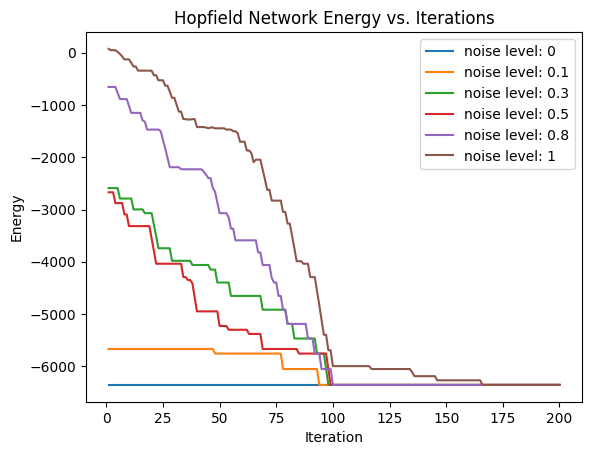

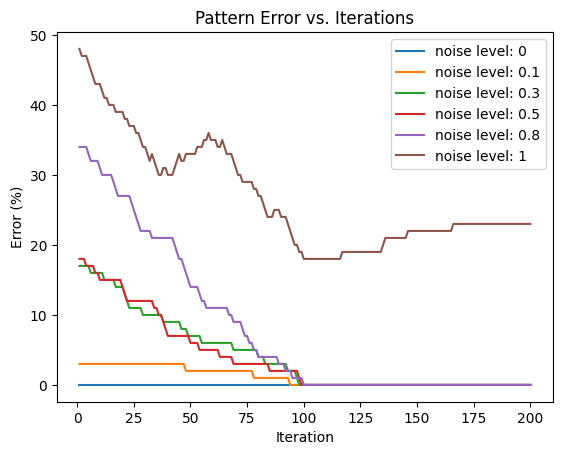

In [ ]:
for i, noise in enumerate(noise_level_list):
    plt.plot(np.arange(1, len(energy_list[i])+1), energy_list[i], label="noise level: {}".format(noise))

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Hopfield Network Energy vs. Iterations")
plt.legend()
plt.show()

print()
for i, noise in enumerate(noise_level_list):
    plt.plot(np.arange(1, len(error_list[i])+1), error_list[i], label="noise level: {}".format(noise))

plt.xlabel("Iteration")
plt.ylabel("Error (%)")
plt.title("Pattern Error vs. Iterations")
plt.legend()
plt.show()

# show_image(states)
# show_image(initial_pattern)
# error = compute_error_percentage(states, [initial_pattern])
# print(error)

## Hopfield Energy/Error vs. Number of Stored Patterns

In [ ]:
SP_number_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
noise_level = 0.1
energy_list = []
error_list = []
dimension = 10
initial_pattern = digit_matrix(0, dimension)

print("""
number of nodes: {}
noise level: {}""".format(dimension*dimension, noise_level))

for SP_number in SP_number_list:
    print("number of SP: {}".format(SP_number))
    patterns = generate_digit_patterns(10, dimension)[0:SP_number]
    energy_values = []
    error_values = []
    initialize()
    for i in range(3):
        update()
    energy = compute_energy(states)
    energy_list.append(energy)
    error = compute_error_percentage(states, [initial_pattern])
    error_list.append(error)


number of nodes: 100
noise level: 0.1
number of SP: 1
number of SP: 2
number of SP: 3
number of SP: 4
number of SP: 5
number of SP: 6
number of SP: 7
number of SP: 8
number of SP: 9
number of SP: 10


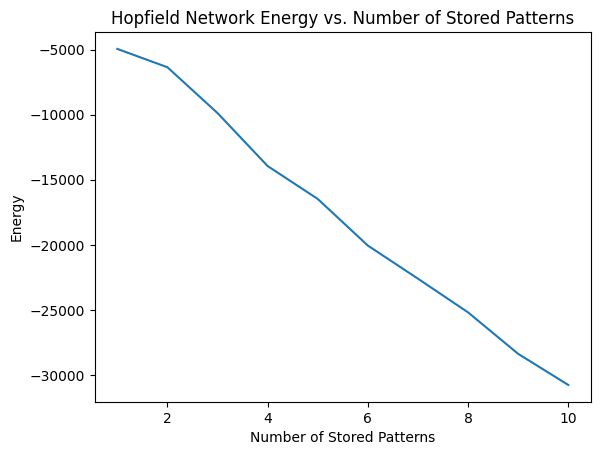

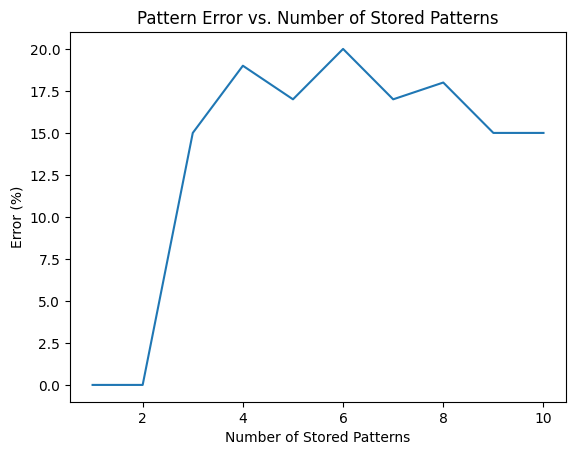

In [ ]:
plt.plot(SP_number_list, energy_list)
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Energy")
plt.title("Hopfield Network Energy vs. Number of Stored Patterns")
plt.show()

print()
plt.plot(SP_number_list, error_list)

plt.xlabel("Number of Stored Patterns")
plt.ylabel("Error (%)")
plt.title("Pattern Error vs. Number of Stored Patterns")
plt.show()

## Hopfield Energy/Error vs Number of Nodes with Different Stored Patterns

In [ ]:
SP_number_list = [1, 2, 3, 4, 5, 6, 7, 8]
dimension_list = np.arange(6, 25)
noise_level = 0.1
energy_list = []
error_list = []

print("""
noise level: {}""".format(noise_level))

for SP_number in SP_number_list:
    print("number of SP: {}".format(SP_number))
    energy_values = []
    error_values = []
    for dim in dimension_list:
        dimension = dim
        patterns = generate_digit_patterns(10, dimension)[0:SP_number]
        initial_pattern = digit_matrix(0, dimension)
        initialize()
        for i in range(3):
            update()

        energy = compute_energy(states)
        energy_values.append(energy)
        error = compute_error_percentage(states, [initial_pattern])
        error_values.append(error)

    energy_list.append(energy_values)
    error_list.append(error_values)


noise level: 0.1
number of SP: 1
number of SP: 2
number of SP: 3
number of SP: 4
number of SP: 5
number of SP: 6
number of SP: 7
number of SP: 8


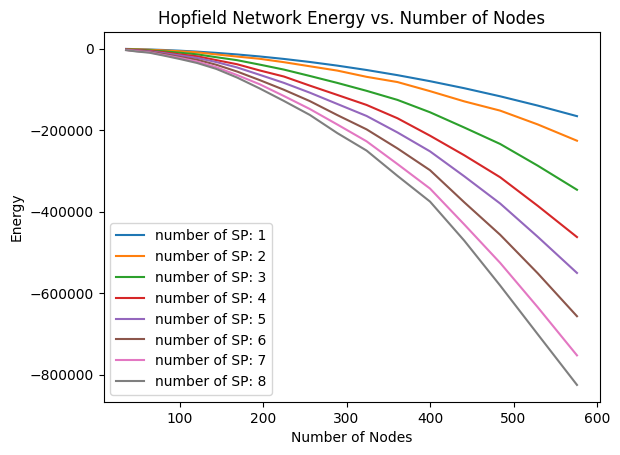

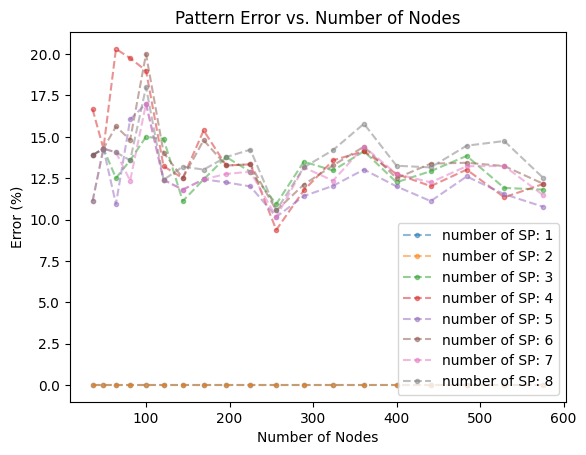

In [ ]:
for i, SP_number in enumerate(SP_number_list):
    plt.plot(np.square(dimension_list), energy_list[i], label="number of SP: {}".format(SP_number))

plt.xlabel("Number of Nodes")
plt.ylabel("Energy")
plt.title("Hopfield Network Energy vs. Number of Nodes")
plt.legend()
plt.show()

print()
for i, SP_number in enumerate(SP_number_list):
    plt.plot(np.square(dimension_list), error_list[i], label="number of SP: {}".format(SP_number), marker='.', linestyle='--', alpha=0.5)

plt.xlabel("Number of Nodes")
plt.ylabel("Error (%)")
plt.title("Pattern Error vs. Number of Nodes")
plt.legend()
plt.show()

## Hopfield Energy/Error vs Noise at Different Number of Stored Patterns

In [ ]:
SP_number_list = [1, 2, 3, 4, 5, 6, 7, 8]
noise_list = np.linspace(0, 1, 20)
dimension = 10
noise_level = 0.1
energy_list = []
error_list = []

print("""
number of nodes: {}""".format(dimension*dimension))

for SP_number in SP_number_list:
    print("number of SP: {}".format(SP_number))
    energy_values = []
    error_values = []
    for noise in noise_list:
        noise_level = noise
        patterns = generate_digit_patterns(10, dimension)[0:SP_number]
        initial_pattern = digit_matrix(0, dimension)
        initialize()
        for i in range(3):
            update()

        energy = compute_energy(states)
        energy_values.append(energy)
        error = compute_error_percentage(states, [initial_pattern])
        error_values.append(error)

    energy_list.append(energy_values)
    error_list.append(error_values)


number of nodes: 100
number of SP: 1
number of SP: 2
number of SP: 3
number of SP: 4
number of SP: 5
number of SP: 6
number of SP: 7
number of SP: 8


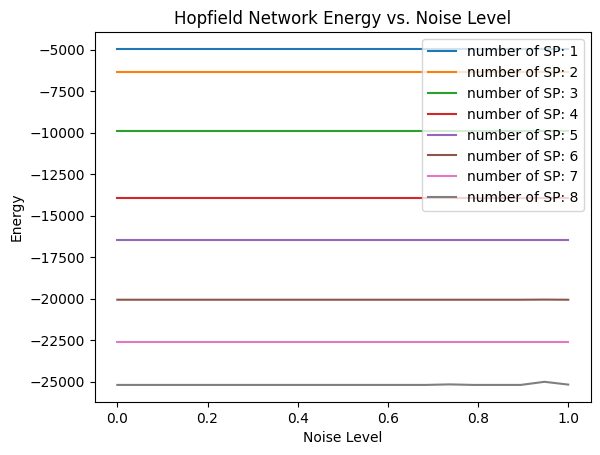

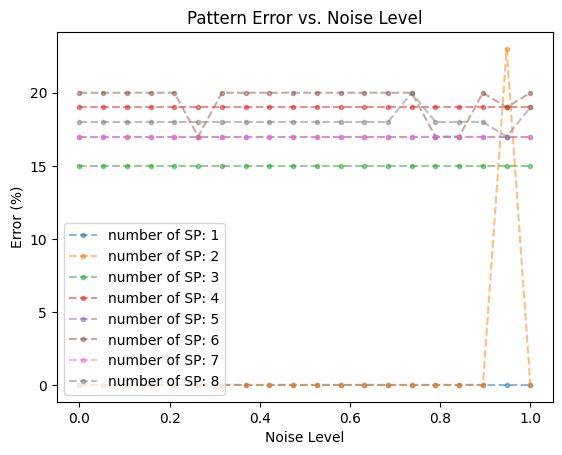

In [ ]:
for i, SP_number in enumerate(SP_number_list):
    plt.plot(noise_list, energy_list[i], label="number of SP: {}".format(SP_number))

plt.xlabel("Noise Level")
plt.ylabel("Energy")
plt.title("Hopfield Network Energy vs. Noise Level")
plt.legend(loc="upper right")
plt.show()

print()
for i, SP_number in enumerate(SP_number_list):
    plt.plot(noise_list, error_list[i], label="number of SP: {}".format(SP_number), marker='.', linestyle='--', alpha=0.5)

plt.xlabel("Noise Level")
plt.ylabel("Error (%)")
plt.title("Pattern Error vs. Noise Level")
plt.legend(loc="lower left")
plt.show()